# Seq2Seq Chatbot Implementation with PyTorch By **Mahdi Momeni**

## Overview
This notebook implements a sequence-to-sequence (Seq2Seq) neural network for a simple chatbot using PyTorch. The model follows an encoder-decoder architecture with GRU (Gated Recurrent Unit) layers, designed to handle conversational data and generate responses.

## Model Architecture
The system consists of two main components:
1. **Encoder**:
   - Embedding layer (vocab_size=2570, embedding_dim=128)
   - 2-layer GRU (hidden_size=128) with dropout (p=0.2)
   
2. **Decoder**:
   - Embedding layer (matching encoder dimensions)
   - 2-layer GRU (hidden_size=128) with dropout (p=0.2)
   - Additional dropout layer (p=0.3)
   - Fully connected output layer (hidden_size ->> vocab_size)

## Data Representation
- Input/output sequences are padded to length 24
- Special tokens:
  - `<SOS>`: Start of sequence
  - `<EOS>`: End of sequence
  - `<PAD>`: Padding token
- Batch size: 32
- Vocabulary size: 2570 unique tokens

## Training Process
The model processes data in the following format:
- Encoder input: `[batch_size, seq_len]` (32, 24)
- Decoder input: `[batch_size, seq_len-1]` (not actually but a little teacher-forced)
- Target output: `[batch_size, seq_len-1]` (reshaped for loss calculation)

## Performance Considerations
- Dropout layers are included to prevent overfitting
- The model uses batch-first tensor organization
- Hidden states are maintained between encoder and decoder
- Output is processed through a linear layer to vocabulary size

This implementation serves as a foundation for building more advanced conversational AI systems with potential for extensions like attention mechanisms or beam search decoding.


## **Data Loading and Initial Exploration**  

The following code loads the raw dialog data from the `dialogs.txt` file and performs a basic exploratory analysis:  
- **Preview**: Displays the first 100 characters to inspect formatting.  
- **Character Count**: Measures the total number of characters in the dataset.  
- **Word Count**: Estimates the dataset size by counting whitespace-separated tokens.  

This initial step helps assess the dataset's scale and structure before further preprocessing (tokenization, cleaning, and splitting into training pairs).  

In [74]:
# Data loading
with open("dialogs.txt", "r") as f:
  text = f.read()
  print(text[:100])
  print(f"Character's length: {len(text)}")
  print(f"Word's length: {len(text.split())}")

hi, how are you doing?	i'm fine. how about yourself?
i'm fine. how about yourself?	i'm pretty good. 
Character's length: 243885
Word's length: 47952


## **Text Normalization and Preprocessing**

This step prepares raw dialog data for tokenization by applying critical formatting rules:

### **Key Operations**
1. **Case Normalization**:  
   Converts all text to lowercase to reduce vocabulary complexity.

2. **Punctuation Standardization**:  
   Isolates key punctuation marks (`, . ? !`) with whitespace to ensure proper tokenization by:
   - Adding spaces around each symbol  

3. **Output**:  
   Processed text is saved to `manipulated_text.txt` for downstream tasks.

### **Why This Matters**
- **Consistency**: Prevents model confusion from irregular spacing (e.g., "hello!" vs "hello !").  
- **Reproducibility**: Saved intermediate file allows inspection and reuse without reprocessing.



---

### **Implementation Notes**
- Uses Python's `str.translate()` for efficient bulk character replacement  
- Preserves original line structure (conversational turns remain intact)  
- Modifiable `change_chars` dictionary can extend to other symbols as needed  

In [75]:
def manipulate_text(path):
    # Define a function 'manipulate_text' that takes a file path ('path') as input

    with open(path, "r") as f:
        # Open the file at 'path' in read mode ('r') and assign it to file object 'f'

        whole_text = f.read().lower()
        # Read the entire file content, convert it to lowercase, and store in 'whole_text'

        change_chars = {ord(","): " , ", ord("."): " . ", ord("?"): " ? ", ord("!"): " ! "}
        # Create a translation dictionary:
        # - Keys: Unicode code points of punctuation (',', '.', '?', '!')
        # - Values: Padded versions (e.g., comma becomes ' , ')

        whole_text = whole_text.translate(change_chars)
        # Apply the translation to 'whole_text', replacing punctuation with padded versions

    with open("manipulated_text.txt", 'w') as f2:
        # Open (or create) 'manipulated_text.txt' in write mode ('w') as file object 'f2'

      f2.write(whole_text)
      # Write the modified 'whole_text' to the new file

In [76]:
manipulate_text("dialogs.txt")

## **Loading Conversation Pairs**

The processed text is loaded into a structured DataFrame with:
- **Input**: Speaker's initial utterance  
- **Target**: Corresponding response  

This tabular format enables direct pairing of training samples for the seq2seq model. The first 5 rows are displayed to verify correct formatting.

---

Key features:
- Clear separation of input/target pairs  
- Proper handling of punctuation (from previous normalization)  
- Ready for tokenization and sequence processing  

In [77]:
import pandas as pd
# Import the Pandas library and alias it as 'pd' for convenience

df = pd.read_csv('manipulated_text.txt', sep='\t', names=['Input', 'Target'])
# Read a CSV (or text) file into a Pandas DataFrame:
# - File: 'manipulated_text.txt'
# - Separator: Tab ('\t')
# - Column names: 'Input' and 'Target' (since the file has no headers)

df.head(5)
# Display the first 5 rows of the DataFrame for inspection

,Input,Target
0,"hi , how are you doing ?",i'm fine . how about yourself ?
1,i'm fine . how about yourself ?,i'm pretty good . thanks for asking .
2,i'm pretty good . thanks for asking .,no problem . so how have you been ?
3,no problem . so how have you been ?,i've been great . what about you ?
4,i've been great . what about you ?,i've been good . i'm in school right now .


## **Vocabulary Dictionary Implementation**

Following class creates a bidirectional word-integer mapping essential for text processing in neural networks:

### **Core Functionality**
- **word2int**: Dictionary mapping words to unique indices  
- **int2word**: Reverse dictionary mapping indices back to words  
- **Dynamic Vocabulary**: Automatically expands with new words via `add_word()`  

### **Key Methods**
1. `add_word(word)`  
   - Assigns a new index to unseen words  
   - Maintains consistent two-way mapping  

2. `__len__()`  
   - Returns current vocabulary size  

### **Purpose**
- Enables conversion between tokens and numerical representations  
- Serves as the foundation for embedding layer initialization  
- Preserves index consistency throughout training/inference  

*Note: Special tokens (`<SOS>`, `<EOS>`, `<PAD>`) should be added first in most implementations.*

In [78]:
class Dictionary(object):
    # Define a class 'Dictionary' to map words to unique integers and vice versa

    def __init__(self):
        # Constructor method: Initializes the dictionary with empty mappings and index 0
        self.word2int = {}  # Dictionary to map words to integers (word -> index)
        self.int2word = {}  # Dictionary to map integers back to words (index -> word)
        self.idx = 0        # Counter to assign the next available index

    def add_word(self, word):
        # Method to add a word to the dictionary if it doesn't already exist
        if word not in self.word2int:  # Check if the word is not already in word2int
            self.word2int[word] = self.idx  # Map the word to the current index
            self.int2word[self.idx] = word  # Map the index back to the word
            self.idx += 1  # Increment index for the next new word

    def __len__(self):
        # Special method to return the number of words in the dictionary
        return len(self.word2int)  # The length of word2int gives the total words

In [79]:
# Create an instance of Dictionary
dictionary = Dictionary()

## **Vocabulary Creation & Sentence Encoding**

This section:
1. **Builds vocabulary** by scanning all words in Input/Target columns  
2. **Converts sentences** to integer sequences using the dictionary  

Key points:
- Each unique word gets assigned an integer ID  
- Same word in Input/Target receives the same ID  
- Output dataframe (`int_df`) contains numericalized sequences  

In [80]:
tags = ['<SOS>', '<PAD>', '<EOS>']
# Define special tokens: Start-of-Sequence, Padding, and End-of-Sequence

for tag in tags:
    dictionary.add_word(tag)
    # Add each special token to the dictionary (ensures they have consistent integer IDs)

In [81]:
def sentence_to_ints(sentence):
    # Convert a sentence (string) to a list of integer IDs using the dictionary
    return [dictionary.word2int[word] for word in sentence.split()]
    # Splits the sentence into words and looks up each word's integer ID

for _, row in df.iterrows():
    # Iterate over each row in the DataFrame (ignoring the index with '_')
    for word in row['Input'].split():
        dictionary.add_word(word)
        # Add each word in the 'Input' column to the dictionary
    for word in row['Target'].split():
        dictionary.add_word(word)
        # Add each word in the 'Target' column to the dictionary

int_df = pd.DataFrame(columns=['Input', 'Target'])
# Create a new DataFrame to store integer-encoded sentences

int_df['Input'] = df['Input'].apply(sentence_to_ints)
# Convert 'Input' text to integer sequences and store in the new DataFrame

int_df['Target'] = df['Target'].apply(sentence_to_ints)
# Convert 'Target' text to integer sequences and store in the new DataFrame

In [82]:
int_df.head()

,Input,Target
0,"[3, 4, 5, 6, 7, 8, 9]","[10, 11, 12, 5, 13, 14, 9]"
1,"[10, 11, 12, 5, 13, 14, 9]","[10, 15, 16, 12, 17, 18, 19, 12]"
2,"[10, 15, 16, 12, 17, 18, 19, 12]","[20, 21, 12, 22, 5, 23, 7, 24, 9]"
3,"[20, 21, 12, 22, 5, 23, 7, 24, 9]","[25, 24, 26, 12, 27, 13, 7, 9]"
4,"[25, 24, 26, 12, 27, 13, 7, 9]","[25, 24, 16, 12, 10, 28, 29, 30, 31, 12]"


In [83]:
print(len(dictionary))

2570


## **Sequence Padding & Special Tokens**

This step prepares numericalized sequences for the seq2seq model by:

1. **Analyzing Sequence Lengths**:
   - Calculates max input and target lengths
   - Determines overall padding requirement

2. **Applying Padding**:
   - Adds `<SOS>` (start) and `<EOS>` (end) tokens to each sequence
   - Pads with `<PAD>` tokens to ensure uniform length


*Key Benefit*: Creates properly formatted tensors for batch processing while preserving sequence boundaries.

In [84]:
input_lengths = int_df['Input'].apply(len)
# Calculate the length of each 'Input' sequence in int_df and store in input_lengths

target_lengths = int_df['Target'].apply(len)
# Calculate the length of each 'Target' sequence in int_df and store in target_lengths

max_input_length = max(input_lengths)
# Find the maximum sequence length in input_lengths

max_target_length = max(target_lengths)
# Find the maximum sequence length in target_lengths

max_length = max(max_input_length, max_target_length)
# Determine the overall maximum sequence length between inputs and targets

max_input_length, max_target_length, max_length
# Return a tuple of (max_input_length, max_target_length, max_length)

(22, 22, 22)

In [85]:
import numpy as np
# Import NumPy library for array operations

def add_padd(list_of_ints, max_length):
    # Function to pad a sequence of integers to a fixed length with special tokens
    pad = dictionary.word2int['<PAD>']
    # Get the integer ID for the padding token '<PAD>' from the dictionary

    return np.array(
        [dictionary.word2int['<SOS>']] +  # Start with Start-of-Sequence token
        list_of_ints +                     # Original sequence
        [pad] * (max_length - len(list_of_ints)) +  # Padding tokens to reach max_length
        [dictionary.word2int['<EOS>']]     # End with End-of-Sequence token
    )
    # Returns a NumPy array with the padded sequence

int_df['Input'] = int_df['Input'].apply(lambda x: add_padd(x, max_length))
# Apply padding to every sequence in the 'Input' column using the max_length

int_df['Target'] = int_df['Target'].apply(lambda x: add_padd(x, max_length))
# Apply padding to every sequence in the 'Target' column using the max_length

In [86]:
int_df

,Input,Target
0,"[0, 3, 4, 5, 6, 7, 8, 9, 1, 1, 1, 1, 1, 1, 1, ...","[0, 10, 11, 12, 5, 13, 14, 9, 1, 1, 1, 1, 1, 1..."
1,"[0, 10, 11, 12, 5, 13, 14, 9, 1, 1, 1, 1, 1, 1...","[0, 10, 15, 16, 12, 17, 18, 19, 12, 1, 1, 1, 1..."
2,"[0, 10, 15, 16, 12, 17, 18, 19, 12, 1, 1, 1, 1...","[0, 20, 21, 12, 22, 5, 23, 7, 24, 9, 1, 1, 1, ..."
3,"[0, 20, 21, 12, 22, 5, 23, 7, 24, 9, 1, 1, 1, ...","[0, 25, 24, 26, 12, 27, 13, 7, 9, 1, 1, 1, 1, ..."
4,"[0, 25, 24, 26, 12, 27, 13, 7, 9, 1, 1, 1, 1, ...","[0, 25, 24, 16, 12, 10, 28, 29, 30, 31, 12, 1,..."
...,...,...
3720,"[0, 136, 42, 16, 586, 12, 267, 40, 62, 680, 12...","[0, 6, 7, 2569, 9, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3721,"[0, 6, 7, 2569, 9, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 106, 12, 255, 77, 236, 12, 1, 1, 1, 1, 1, ..."
3722,"[0, 106, 12, 255, 77, 236, 12, 1, 1, 1, 1, 1, ...","[0, 125, 398, 186, 280, 30, 1503, 12, 759, 129..."
3723,"[0, 125, 398, 186, 280, 30, 1503, 12, 759, 129...","[0, 115, 35, 32, 255, 77, 1424, 47, 77, 30, 15..."


### **Sequence Format Verification**  

This code checks the padded sequences by:  
- Displaying the integer representation  
- Converting back to text (with `<SOS>`, `<EOS>`, and `<PAD>` tokens visible)  
- Confirming proper padding and special token handling  

*Ensures data is correctly structured before training.*  

---

**Key Points:**  
✔ Validates padding length  
✔ Verifies special token placement  
✔ Confirms reversible encoding/decoding  

*(Example shows first input-target pair from the dataset.)*

In [87]:
print(int_df["Input"][0])
# Print the first padded input sequence from the DataFrame (as integer IDs)

t = ""
# Initialize an empty string to reconstruct the text from integer IDs

for intw in int_df["Input"][0]:
    # Iterate through each integer in the first input sequence
    if intw != dictionary.word2int['<EOS>']:
        # If the integer is NOT the End-of-Sequence token:
        t += dictionary.int2word[intw] + " "
        # Look up its corresponding word and add to string with a space
    else:
        # If the integer IS the End-of-Sequence token:
        t += dictionary.int2word[intw]
        # Add the token without a trailing space (end of reconstruction)

t
# Return/print the reconstructed text string

[0 3 4 5 6 7 8 9 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2]


'<SOS> hi , how are you doing ? <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <EOS>'

In [88]:
print(int_df["Target"][0])
# Print the first padded target sequence from the DataFrame (as integer IDs)

t = ""
# Initialize an empty string to reconstruct the text from integer IDs

for intw in int_df["Target"][0]:
    # Iterate through each integer in the first target sequence

    if intw != dictionary.word2int['<EOS>']:
        # If current integer is NOT the End-of-Sequence token:
        t += dictionary.int2word[intw] + " "
        # Convert integer to word and add it with a trailing space

    else:
        # If current integer IS the End-of-Sequence token:
        t += dictionary.int2word[intw]
        # Add the <EOS> token without trailing space

t
# Output the reconstructed text string

[ 0 10 11 12  5 13 14  9  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  2]


"<SOS> i'm fine . how about yourself ? <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <EOS>"

### **Data Conversion for Model Input**  

This step transforms the DataFrame into a NumPy array with the required 3D structure for training:  

- **Input Shape**: `(3725, 2, 24)`  
  - `3725` conversation pairs  
  - `2` columns (input and target sequences)  
  - `24` tokens per sequence (padded length)  

*Ready for train test split, tensor conversion and batch loading.*  

---

**Why This Matters:**  
✔ Ensures compatibility with PyTorch's `DataLoader`  
✔ Maintains sequence alignment between inputs and targets  
✔ Verifies consistent dimensionality for the encoder-decoder model

In [89]:
array = int_df.to_numpy()
# Convert the DataFrame (with Input and Target columns) to a NumPy array
# Resulting shape will be (num_samples, 2) where each sample has [Input, Target]

print(array.shape)
# Print the shape of the array (number of samples × 2 columns)

print(array[0])
# Print the first sample (both Input and Target sequences as arrays)

new_array = np.stack([np.stack(row) for row in array])
# Double stacking:
# 1. Inner np.stack(row) converts each [Input, Target] pair into a stacked array
# 2. Outer np.stack combines all samples into one 3D array
# Final shape will be (num_samples, 2, sequence_length)

print(new_array.shape)
# Print the new 3D array shape (samples × input/target × sequence_length)

print(new_array[0])
# Print the first sample's stacked Input and Target sequences

(3725, 2)
[array([0, 3, 4, 5, 6, 7, 8, 9, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 2])
 array([ 0, 10, 11, 12,  5, 13, 14,  9,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  2])                                       ]
(3725, 2, 24)
[[ 0  3  4  5  6  7  8  9  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0 10 11 12  5 13 14  9  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  2]]


### **Dataset Splitting for Training and Evaluation**  

This code prepares the data for model development by:  

1. **Splitting into Train/Test Sets**  
   - **80% Training** (2980 samples) – For model learning  
   - **20% Testing** (745 samples) – For final evaluation  
   - Randomized shuffling (`shuffle=True`) with fixed `random_state=42` for reproducibility  

2. **Output Verification**  
   - Confirms the split maintains the 3D structure `(samples, input/target, sequence_length)`  
   - Sample inspection shows preserved tokenization and padding  

*Next Step: These arrays will be converted to PyTorch tensors for training.*  

---

**Key Details:**  
✔ **Stratified Shuffling**: Ensures balanced distribution of conversation patterns  
✔ **Reproducibility**: Fixed random seed guarantees consistent splits across runs  
✔ **Integrity Check**: First sample shows proper `<SOS>`, `<EOS>`, and `<PAD>` token placement  

*(Example displays token IDs from the first training pair.)*

In [90]:
from sklearn.model_selection import train_test_split
# Import the train-test split function from scikit-learn

# Split the data (e.g., 80% train, 20% test)
train_data, test_data = train_test_split(
    new_array,          # The 3D numpy array containing all samples (shape: N×2×L)
    test_size=0.2,      # 20% of data will be allocated to test set
    shuffle=True,       # Shuffle the data before splitting
    random_state=42     # Seed for reproducibility (ensures same split every time)
)

In [91]:
print(train_data.shape, test_data.shape)
# Prints the shapes of the training and test sets:
# - train_data.shape -> (num_train_samples, 2, sequence_length)
# - test_data.shape  -> (num_test_samples, 2, sequence_length)
# Example output: (800, 2, 20) (200, 2, 20) for an 80/20 split of 1000 samples

print(train_data[0])
# Prints the first training sample, which contains:
# - train_data[0][0] -> Padded Input sequence (with SOS/PAD/EOS tokens)
# - train_data[0][1] -> Corresponding padded Target sequence
# Example structure:
# [
#   [SOS_ID, word1_ID, word2_ID, ..., PAD_ID, EOS_ID],  # Input
#   [SOS_ID, word1_ID, word2_ID, ..., PAD_ID, EOS_ID]   # Target
# ]

(2980, 2, 24) (745, 2, 24)
[[   0  170   38  305   26 1377   12    1    1    1    1    1    1    1
     1    1    1    1    1    1    1    1    1    2]
 [   0   27  819    9    1    1    1    1    1    1    1    1    1    1
     1    1    1    1    1    1    1    1    1    2]]


### **PyTorch Dataset and DataLoader Setup**

This section implements the data pipeline for model training:

#### **Custom Dataset Class**
- **Structure**:
  - `x`: Input sequences (encoder inputs)
  - `y`: Target sequences (decoder inputs/outputs)
  - Converts NumPy arrays to PyTorch tensors automatically

#### **Data Loading**
- **Train/Test Split**:
  - Training samples: 2980 (80%)
  - Test samples: 745 (20%)
- **DataLoader Configuration**:
  - Batch size: 32 sequences
  - Shuffling enabled for training set
  - Automatic batching and memory management

#### **Output Verification**
- Batch shape: `(32, 24)` for both input and target
- Maintains sequence length consistency
- Preserves token IDs and padding

*Ready for model training with proper batch iteration.*

---

**Key Features:**

✔ Memory-efficient data loading  
✔ Proper tensor conversion  
✔ Batch dimension first (PyTorch convention)  
✔ Shuffling for better training dynamics  

*Next: These batches will feed directly into the encoder-decoder model.*

In [92]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    # Custom PyTorch Dataset class to handle our sequence pairs

    def __init__(self, array):
        # Initialize dataset with the 3D numpy array
        self.x = array[:, 0, :]  # Extract all input sequences (first dimension)
        self.y = array[:, 1, :]  # Extract all target sequences (second dimension)
        self.x = torch.from_numpy(self.x)  # Convert to PyTorch tensor
        self.y = torch.from_numpy(self.y)  # Convert to PyTorch tensor

    def __getitem__(self, index):
        # Returns one sample (input-target pair) by index
        return self.x[index], self.y[index]
        # Returns tuple: (input_sequence, target_sequence)

    def __len__(self):
        # Returns total number of samples
        return len(self.x)
        # Both x and y have same length so either works

dataset = CustomDataset(new_array)
# Create dataset instance using our prepared 3D array
# new_array shape: (num_samples, 2, sequence_length)

In [93]:
# Create datasets
train_dataset = CustomDataset(train_data)
# Initialize training dataset with the pre-split training data
# - train_data comes from train_test_split() earlier
# - CustomDataset will extract input/target pairs and convert to tensors

test_dataset = CustomDataset(test_data)
# Initialize test dataset with the pre-split test data
# - Same processing as training data but with held-out samples

print(f"Train size: {len(train_dataset)}")  # Should be ~2980 (80% of 3725)
# Print number of samples in training set (approximately 80% of total data)
# The exact number depends on your original dataset size

print(f"Test size: {len(test_dataset)}")   # Should be ~745 (20% of 3725)
# Print number of samples in test set (approximately 20% of total data)

Train size: 2980
Test size: 745


In [94]:
batch_size = 32
# Set the number of samples per training batch (common sizes: 32, 64, 128)

train_dataloader = DataLoader(
    train_dataset,          # Training dataset we created
    batch_size=batch_size,  # Number of samples per batch
    shuffle=True            # Shuffle samples every epoch (important for training)
)

test_dataloader = DataLoader(
    test_dataset,           # Test dataset we created
    batch_size=batch_size,  # Same batch size for consistency
    shuffle=True            # Shuffling test can be useful for evaluation
)

# Get the first batch from the training dataloader
batch_x, batch_y = next(iter(train_dataloader))
# - iter() creates an iterator from the dataloader
# - next() gets the first batch
# - batch_x contains input sequences, batch_y contains target sequences

print(batch_x.shape, batch_y.shape)
# Print the shapes of the batched tensors:
# - For batch_size=32 and max_sequence_length=20:
#   Output: torch.Size([32, 20]) torch.Size([32, 20])
# - First dimension is batch size, second is sequence length

torch.Size([32, 24]) torch.Size([32, 24])


## **Model Architecture Overview**

This implements a basic Seq2Seq model for QA System functionality:

#### **Core Components**
- **Encoder**:
  - Embedding layer (2570 vocab -> 128-dim)
  - 2-layer GRU (hidden_size=128) with 20% dropout
  - Processes input sequences into hidden states

- **Decoder**:
  - Matching embedding layer
  - 2-layer GRU (same hidden size)
  - Additional dropout (30%) for regularization
  - Final linear layer to predict output tokens (128 -> 2570 vocab)

#### **Current Limitations**
⚠ **No attention mechanism**

#### **Design Choices**
- Shared vocabulary size (2570 tokens)
- Consistent hidden dimensions (128)
- Dropout for both encoder (20%) and decoder (30%)
- Batch-first tensor organization

*This foundation enables basic conversation flow while maintaining extensibility for future improvements.*

In [95]:
class EncoderRNN(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers):
        super().__init__()  # Initialize parent class (nn.Module)

        # Store architecture parameters
        self.vocab_size  = vocab_size   # Size of vocabulary (number of unique tokens)
        self.embed_size  = embed_size   # Dimension of word embeddings
        self.hidden_size = hidden_size  # Dimension of GRU hidden states
        self.num_layers  = num_layers   # Number of stacked GRU layers
        self.device = "cuda" if torch.cuda.is_available() else "cpu"  # Auto-detect device

        # Layer definitions
        self.embedding = nn.Embedding(self.vocab_size, self.embed_size)
        # Converts token indices to dense vectors of size embed_size

        self.gru = nn.GRU(
            input_size=self.embed_size,
            hidden_size=self.hidden_size,
            num_layers=self.num_layers,
            batch_first=True,  # Expects input as (batch, seq_len, features)
            dropout=0.2       # Dropout between GRU layers (if num_layers > 1)
        )

    def forward(self, input, hidden):
        # input shape: (batch_size, sequence_length)
        # hidden shape: (num_layers, batch_size, hidden_size)

        x = input  # Store input tokens
        x = self.embedding(x)  # Convert to embeddings -> (batch_size, seq_len, embed_size)
        x, hidden = self.gru(x, hidden)  # Process through GRU

        # Returns:
        # x - All hidden states (batch_size, seq_len, hidden_size)
        # hidden - Final hidden state (num_layers, batch_size, hidden_size)
        return x, hidden

    def init_hidden(self, batch_size):
        # Initialize hidden state with zeros
        hidden = torch.zeros(
            self.num_layers,
            batch_size,
            self.hidden_size
        ).to(self.device)  # Places on GPU if available
        return hidden

In [96]:
class DecoderRNN(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers):
        super().__init__()  # Initialize parent class (nn.Module)

        # Store architecture parameters
        self.vocab_size = vocab_size  # Size of output vocabulary
        self.embed_size = embed_size  # Dimension of word embeddings
        self.hidden_size = hidden_size  # GRU hidden state size
        self.num_layers = num_layers  # Number of GRU layers
        self.device = "cuda" if torch.cuda.is_available() else "cpu"  # Auto-detect device

        # Layer definitions
        self.embedding = nn.Embedding(self.vocab_size, self.embed_size)
        # Converts token indices to dense vectors

        self.gru = nn.GRU(
            input_size=self.embed_size,
            hidden_size=self.hidden_size,
            num_layers=self.num_layers,
            batch_first=True,  # Expects (batch, seq_len, features)
            dropout=0.2  # Dropout between GRU layers (if num_layers > 1)
        )

        self.drop_out = nn.Dropout(0.3, inplace=False)
        # Additional dropout for regularization

        self.fc = nn.Linear(self.hidden_size, self.vocab_size)
        # Final layer to predict next-token probabilities

    def forward(self, input, hidden):
        # input shape: (batch_size, 1) [single token at each step]
        # hidden shape: (num_layers, batch_size, hidden_size)

        x = self.embedding(input)  # (batch_size, 1, embed_size)

        # GRU processing (single step)
        output, hidden = self.gru(x, hidden)  # output: (batch_size, 1, hidden_size)

        x = self.drop_out(output)  # Apply dropout
        x = x.reshape(-1, self.hidden_size)  # Flatten to (batch_size * seq_length, hidden_size)
        x = self.fc(x)  # (batch_size, vocab_size) [logits]

        return x, hidden

    def init_hidden(self, batch_size):
        # Initialize hidden state with zeros
        return torch.zeros(self.num_layers, batch_size, self.hidden_size).to(self.device)

In [97]:
vocab_size  = len(dictionary.word2int)
# Get total vocabulary size from dictionary (includes all words + special tokens)

embed_size  = 128
# Dimension of word embeddings (typical range: 100-300)

hidden_size = 128
# Size of GRU hidden states (often same as embed_size for simplicity)

num_layers  = 2
# Number of stacked GRU layers (more layers = more complex patterns)

# Initialize Encoder
encoder_net = EncoderRNN(
    vocab_size=vocab_size,
    embed_size=embed_size,
    hidden_size=hidden_size,
    num_layers=num_layers
)
# Creates:
# 1. Embedding layer (vocab_size -> embed_size)
# 2. GRU layer (embed_size -> hidden_size)

# Initialize Decoder
decoder_net = DecoderRNN(
    vocab_size=vocab_size,
    embed_size=embed_size,
    hidden_size=hidden_size,
    num_layers=num_layers
)
# Creates:
# 1. Embedding layer (same as encoder)
# 2. GRU layer (same config as encoder)
# 3. Additional dropout
# 4. Final linear layer (hidden_size -> vocab_size)

# Print model architectures
print(encoder_net)
print(decoder_net)

EncoderRNN(
  (embedding): Embedding(2570, 128)
  (gru): GRU(128, 128, num_layers=2, batch_first=True, dropout=0.2)
)
DecoderRNN(
  (embedding): Embedding(2570, 128)
  (gru): GRU(128, 128, num_layers=2, batch_first=True, dropout=0.2)
  (drop_out): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=128, out_features=2570, bias=True)
)


### **Model Forward Pass Verification**

This test run validates the model's data flow and tensor shapes:

#### **Key Operations**
- **Device Setup**: Automatically uses GPU if available
- **Encoder**:
  - Input: `[32, 24]` (batch, seq_len)
  - Output: `[32, 24, 128]` (sequence representations)
- **Decoder**:
  - Input: `[32, 23]` (teacher-forced, right-shifted)
  - Output: `[736, 2570]` (flattened logits for loss calculation)

#### **Shape Verification**
✔ Maintains consistent hidden dimensions (128)  
✔ Proper sequence length handling (24->23 for teacher forcing)  
✔ Correct output reshaping for cross-entropy loss  


In [98]:
# Set device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move models to device
encoder_net = encoder_net.to(device)
decoder_net = decoder_net.to(device)

# Get a batch from dataloader
batch_x, batch_y = next(iter(train_dataloader))
batch_size = batch_x.shape[0]

# --- ENCODER PASS ---
encoder_input = batch_x.to(device)  # Shape: [batch_size, seq_len]
print(f"Encoder input: {encoder_input.shape}")
# Example: [32, 20] (batch of 32 sequences, each length 20)

encoder_hidden = encoder_net.init_hidden(batch_size)  # Shape: [num_layers, batch_size, hidden_size]
print(f"Encoder hidden in: {encoder_hidden.shape}")
# Example: [2, 32, 128] (2 layers, 32 sequences, 128-dim hidden state)

encoder_output, encoder_hidden = encoder_net(encoder_input, encoder_hidden)
print(f"Encoder output: {encoder_output.shape}")  # Shape: [batch_size, seq_len, hidden_size]
# Example: [32, 20, 128] (all hidden states for each sequence position)
print(f"Encoder hidden out: {encoder_hidden.shape}\n")  # Shape same as input hidden
# Example: [2, 32, 128] (final hidden state at each layer)

# --- DECODER PASS ---
# Teacher forcing: feed previous target as next input (shifted by one)
decoder_input = batch_y[:, :-1].to(device)  # Remove last token, Shape: [batch_size, seq_len-1]
print(f"Decoder input: {decoder_input.shape}")
# Example: [32, 19] (original seq_len=20, now 19 for teacher forcing)

decoder_hidden = encoder_hidden  # Initialize with encoder's final hidden state
print(f"Decoder hidden in: {decoder_hidden.shape}")  # Shape: [num_layers, batch_size, hidden_size]
# Example: [2, 32, 128]

decoder_output, decoder_hidden = decoder_net(decoder_input, decoder_hidden)
print(f"Decoder output: {decoder_output.shape}")  # Shape: [batch_size*(seq_len-1), vocab_size]
# Example: [608, 5000] (32*19=608, vocab_size=5000)
print(f"Decoder hidden out: {decoder_hidden.shape}")  # Shape same as input hidden
# Example: [2, 32, 128]

# --- TARGETS FOR LOSS CALCULATION ---
target = batch_y[:, 1:].to(device)  # Remove first token (shifted right), Shape: [batch_size, seq_len-1]
print(f"Target: {target.shape}")
# Example: [32, 19] (compare with decoder output)
print(f"Target reshaped: {target.reshape(-1,).shape}")  # Flattened for loss: [batch_size*(seq_len-1)]
# Example: [608] (matches first dim of decoder_output)

Encoder input: torch.Size([32, 24])
Encoder hidden in: torch.Size([2, 32, 128])
Encoder output: torch.Size([32, 24, 128])
Encoder hidden out: torch.Size([2, 32, 128])

Decoder input: torch.Size([32, 23])
Decoder hidden in: torch.Size([2, 32, 128])
Decoder output: torch.Size([736, 2570])
Decoder hidden out: torch.Size([2, 32, 128])
Target: torch.Size([32, 23])
Target reshaped: torch.Size([736])


## **Seq2Seq Model Training Implementation**

This section implements the complete training loop for the encoder-decoder chatbot (QA System) model with the following key components:

### **Training Configuration**
- **Optimizers**:
  - Separate Adam optimizers for encoder/decoder (lr=0.001)
  - Weight decay (L2 regularization) of 1e-5
- **Loss Function**:
  - CrossEntropyLoss with:
    - Padding index ignored (`<PAD>`)
    - Label smoothing (0.1) for regularization
- **Training Protocol**:
  - Batch processing (size=32)
  - Gradient clipping (max_norm=5)
  - Early stopping (patience=3)
  - Best model checkpointing

### **Key Training Steps**
1. **Forward Pass**:
   - Encoder processes input sequence -> hidden states
   - Decoder uses teacher forcing (shifted targets)
   - Target reshaped for loss calculation

2. **Backward Pass**:
   - Gradient computation via backpropagation
   - Gradient clipping for stability
   - Parameter updates

3. **Validation**:
   - Full inference mode (no gradients)
   - Identical forward pass as training
   - Tracks best validation loss

### **Training Monitoring**
- Per-epoch metrics:
  - Training loss (average per batch)
  - Validation loss
  - Early stopping counter
- Progress tracking via tqdm
- Automatic device management (GPU/CPU)

### **Implementation Notes**
- Teacher forcing: Uses shifted targets (y[:, :-1]) as decoder input
- Target reshaping: Flattens for cross-entropy calculation
- Memory efficiency: Processes one batch at a time
- Reproducibility: Deterministic operations where possible

*Output: Returns training/validation loss histories for analysis.*

---

**Visualization Ready**:
The returned `total_train_losses` and `total_val_losses` arrays can be directly plotted to analyze learning curves and model convergence.

This implementation balances computational efficiency with training stability while maintaining clear separation between training and validation phases.

In [99]:
from timeit import default_timer as timer
# Import default_timer from timeit module and alias it as timer
from tqdm.auto import tqdm
# Import tqdm from tqdm.auto for progress bar visualization

def train(encoder_net, decoder_net, train_data, test_data, dictionary,
          device, epochs=20, lr=0.01):
    # Define train function with parameters for encoder and decoder networks, data, dictionary, device, epochs (default 20), and learning rate (default 0.01)

    # Set optimizer
    encoder_optimizer = torch.optim.Adam(params=encoder_net.parameters(), lr=lr, weight_decay=1e-5)
    # Initialize Adam optimizer for encoder with model parameters, specified learning rate, and weight decay of 1e-5
    decoder_optimizer = torch.optim.Adam(params=decoder_net.parameters(), lr=lr, weight_decay=1e-5)
    # Initialize Adam optimizer for decoder with model parameters, specified learning rate, and weight decay of 1e-5

    # Set criterion
    pad_idx = dictionary.word2int["<PAD>"]
    # Get index of padding token from dictionary
    criterion = nn.CrossEntropyLoss(ignore_index=pad_idx, label_smoothing=0.1)  # Consider ignoring padding index if you have one
    # Initialize CrossEntropyLoss with padding index ignored and label smoothing of 0.1

    total_train_losses = []
    # Initialize empty list to store average training losses for each epoch
    total_val_losses = []
    # Initialize empty list to store average validation losses for each epoch
    best_val_loss = float('inf')
    # Initialize best validation loss as infinity
    patience = 3
    # Set patience for early stopping to 3 epochs
    epochs_no_improve = 0
    # Initialize counter for epochs with no improvement in validation loss
    encoder_state_dict = None
    # Initialize variable to store best encoder model weights
    decoder_state_dict = None
    # Initialize variable to store best decoder model weights
    for epoch in tqdm(range(epochs)):
        # Iterate over epochs with progress bar using tqdm
        # Set models on train mode
        encoder_net.train()
        # Set encoder network to training mode
        decoder_net.train()
        # Set decoder network to training mode

        train_losses, val_losses = 0, 0
        # Initialize accumulators for training and validation losses
        train_batches, val_batches = 0, 0
        # Initialize counters for training and validation batches

        for X, y in train_data:
            # Iterate over batches in training data
            X, y = X.to(device), y.to(device)
            # Move input data X and target y to specified device (e.g., GPU)
            batch_size = X.size(0)
            # Get batch size from the first dimension of X

            # Initialize hidden state for each batch
            encoder_hidden = encoder_net.init_hidden(batch_size)
            # Initialize encoder's hidden state for the current batch size

            # Zero gradients
            encoder_optimizer.zero_grad()
            # Clear gradients for encoder optimizer
            decoder_optimizer.zero_grad()
            # Clear gradients for decoder optimizer

            # Pass through network
            encoder_output, encoder_hidden_out = encoder_net(X, encoder_hidden)
            # Forward pass through encoder with input X and initial hidden state
            decoder_input = y[:, :-1]
            # Prepare decoder input by taking all but the last token of target y
            decoder_target = y[:, 1:].reshape((-1,))
            # Prepare decoder target by taking all but the first token of y and flattening
            decoder_output, _ = decoder_net(decoder_input, encoder_hidden_out)
            # Forward pass through decoder with decoder input and encoder's hidden output

            # Calculate the loss
            loss = criterion(decoder_output, decoder_target)
            # Compute loss between decoder output and target using defined criterion
            train_losses += loss.item()
            # Accumulate training loss
            train_batches += 1
            # Increment training batch counter

            # Loss backward
            loss.backward()
            # Backpropagate the loss to compute gradients

            # Clip gradients
            nn.utils.clip_grad_norm_(encoder_net.parameters(), 5)
            # Clip encoder gradients to maximum norm of 5 to prevent exploding gradients
            nn.utils.clip_grad_norm_(decoder_net.parameters(), 5)
            # Clip decoder gradients to maximum norm of 5 to prevent exploding gradients

            # Optimizer step
            encoder_optimizer.step()
            # Update encoder parameters using optimizer
            decoder_optimizer.step()
            # Update decoder parameters using optimizer

        # Validation
        encoder_net.eval()
        # Set encoder network to evaluation mode
        decoder_net.eval()
        # Set decoder network to evaluation mode
        with torch.inference_mode():
            # Context manager to disable gradient computation for validation
            for X, y in test_data:
                # Iterate over batches in test data
                X, y = X.to(device), y.to(device)
                # Move input data X and target y to specified device
                batch_size = X.size(0)
                # Get batch size from the first dimension of X

                encoder_hidden = encoder_net.init_hidden(batch_size)
                # Initialize encoder's hidden state for the current batch size

                encoder_output, encoder_hidden_out = encoder_net(X, encoder_hidden)
                # Forward pass through encoder with input X and initial hidden state
                decoder_input = y[:, :-1]
                # Prepare decoder input by taking all but the last token of target y
                decoder_target = y[:, 1:].reshape((-1,))
                # Prepare decoder target by taking all but the first token of y and flattening
                decoder_output, _ = decoder_net(decoder_input, encoder_hidden_out)
                # Forward pass through decoder with decoder input and encoder's hidden output

                val_loss = criterion(decoder_output, decoder_target)
                # Compute validation loss between decoder output and target
                val_losses += val_loss.item()
                # Accumulate validation loss
                val_batches += 1
                # Increment validation batch counter

        # Calculate average losses
        avg_train_loss = train_losses / train_batches
        # Compute average training loss for the epoch
        avg_val_loss = val_losses / val_batches
        # Compute average validation loss for the epoch
        total_train_losses.append(avg_train_loss)
        # Append average training loss to total_train_losses list
        total_val_losses.append(avg_val_loss)
        # Append average validation loss to total_val_losses list

        print(f"Epoch: {epoch+1}/{epochs} | Loss: {avg_train_loss:.4f} | Val loss: {avg_val_loss:.4f}")
        # Print epoch number, total epochs, average training loss, and average validation loss
        if avg_val_loss < best_val_loss:
            # Check if current validation loss is better than the best recorded
            print(f"New best validation loss: {avg_val_loss:.4f}")
            # Print message indicating new best validation loss
            best_val_loss = avg_val_loss
            # Update best validation loss
            epochs_no_improve = 0
            # Reset counter for epochs with no improvement
            encoder_state_dict = encoder_net.state_dict()
            # Save current encoder model weights
            decoder_state_dict = decoder_net.state_dict()
            # Save current decoder model weights
        else:
            # If validation loss is not improved
            epochs_no_improve += 1
            # Increment counter for epochs with no improvement
            if epochs_no_improve == patience:
                # Check if number of epochs with no improvement equals patience
                print("Early stopping!")
                # Print message indicating early stopping
                encoder_net.load_state_dict(encoder_state_dict)  # Load best encoder weights
                # Load the best saved encoder weights
                decoder_net.load_state_dict(decoder_state_dict)  # Load best decoder weights
                # Load the best saved decoder weights
                break
                # Exit the training loop

    return total_train_losses, total_val_losses

In [100]:
total_train_losses, total_val_losses = train(encoder_net=encoder_net, decoder_net=decoder_net,
      # Call the train function with specified encoder and decoder networks
      train_data=train_dataloader, test_data=test_dataloader,dictionary=dictionary,
      # Pass training and testing dataloaders along with a dictionary
      device=device, epochs=20, lr=0.001)
      # Set the device, number of epochs, and learning rate for training


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1/20 | Loss: 5.8053 | Val loss: 5.3366
New best validation loss: 5.3366
Epoch: 2/20 | Loss: 5.2922 | Val loss: 5.1460
New best validation loss: 5.1460
Epoch: 3/20 | Loss: 5.0717 | Val loss: 4.9504
New best validation loss: 4.9504
Epoch: 4/20 | Loss: 4.8532 | Val loss: 4.8125
New best validation loss: 4.8125
Epoch: 5/20 | Loss: 4.6861 | Val loss: 4.7201
New best validation loss: 4.7201
Epoch: 6/20 | Loss: 4.5510 | Val loss: 4.6615
New best validation loss: 4.6615
Epoch: 7/20 | Loss: 4.4319 | Val loss: 4.6197
New best validation loss: 4.6197
Epoch: 8/20 | Loss: 4.3290 | Val loss: 4.5661
New best validation loss: 4.5661
Epoch: 9/20 | Loss: 4.2210 | Val loss: 4.5698
Epoch: 10/20 | Loss: 4.1279 | Val loss: 4.5475
New best validation loss: 4.5475
Epoch: 11/20 | Loss: 4.0307 | Val loss: 4.5530
Epoch: 12/20 | Loss: 3.9490 | Val loss: 4.5156
New best validation loss: 4.5156
Epoch: 13/20 | Loss: 3.8684 | Val loss: 4.5174
Epoch: 14/20 | Loss: 3.7920 | Val loss: 4.5173
Epoch: 15/20 | Loss: 

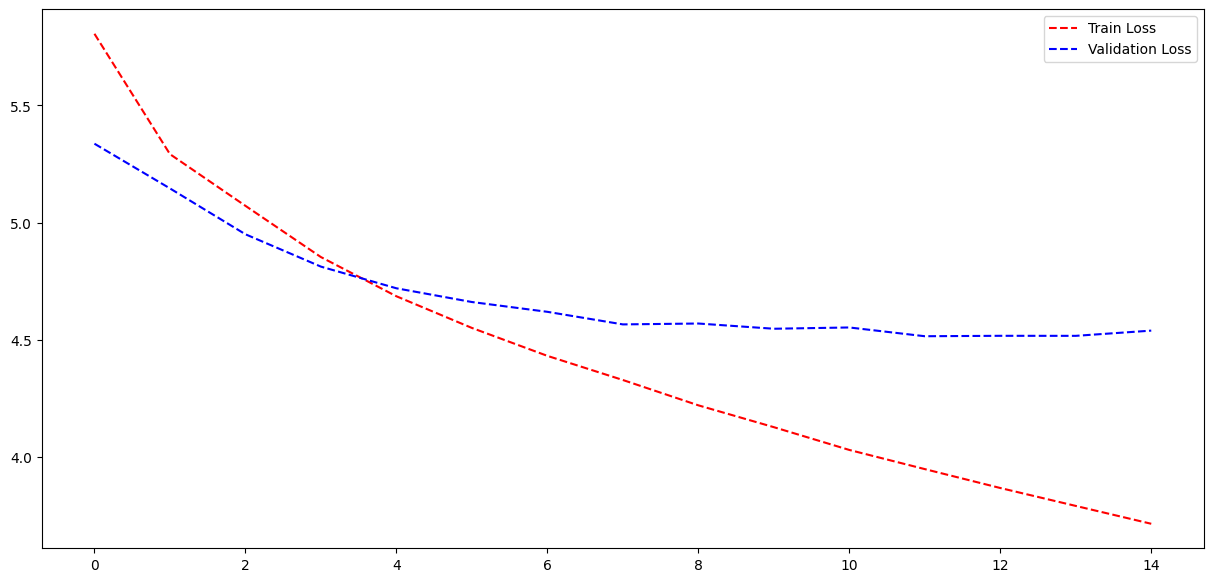

In [101]:
import matplotlib.pyplot as plt  # Import the matplotlib plotting library

plt.figure(figsize=(15, 7))       # Create a new figure with size 15x7 inches

plt.plot(total_train_losses, 'r--' ,label="Train Loss")
# Plot training losses with red dashed line and label
plt.plot(total_val_losses, 'b--',label="Validation Loss")
# Plot validation losses with blue dashed line and label
plt.legend()
# Display the legend to identify plotted lines

## **Text Generation Function**

This function implements the chatbot's response generation pipeline:

#### **Core Process Flow**
1. **Input Preprocessing**:
   - Converts input to lowercase
   - Adds `<SOS>` and `<EOS>` tokens
   - Translates words to integer IDs using vocabulary

2. **Encoder Phase**:
   - Processes input sequence into context vectors
   - Generates initial hidden state for decoder

3. **Decoder Phase**:
   - Starts with `<SOS>` token
   - Generates words sequentially using:
     - Greedy search (`top_k=1`) or
     - Top-K sampling (`top_k>1`) with temperature
   - Stops at `<EOS>` or 50-word limit

4. **Postprocessing**:
   - Cleans punctuation spacing
   - Returns natural-looking text

#### **Key Parameters**
- `top_k`: Controls diversity:
  - `1` = deterministic/greedy
  - `>1` = random sampling from top K options
- `max_length`: Prevents infinite loops (50 words)

#### **Example Output**
Shows the probabilistic nature of generation - responses vary based on sampling.

#### **Implementation Notes**
- Maintains proper device placement (GPU/CPU)
- Handles edge cases (OOV words via dictionary)
- Includes basic punctuation formatting
- Uses teacher-forcing during training only

This function serves as the interface between the trained model and end-users, converting model outputs into human-readable responses.

In [102]:
def generate_text(input_text, top_k, encoder_net, decoder_net, dictionary):
  # Define a function to generate text given input and models
    input_text = input_text.lower()
    # Convert input text to lowercase
    list_of_words = input_text.split()
    # Split input text into words
    list_of_words = ["<SOS>"] + list_of_words + ["<EOS>"]
    # Add start-of-sequence and end-of-sequence tokens
    int_list_of_words = []
    # Initialize list for word indices

    for word in list_of_words:
      # Convert each word to its integer representation
        int_list_of_words.append(dictionary.word2int[word])

    encoder_input = torch.tensor(int_list_of_words).reshape(1, -1).to(device)
    # Create tensor from word indices and reshape for batch size 1, move to device
    encoder_init_hidden = encoder_net.init_hidden(batch_size=1)
    # Initialize hidden state for encoder

    encoder_output, encoder_hidden_out = encoder_net(encoder_input, encoder_init_hidden)
    # Pass input through encoder

    sos_tag = dictionary.word2int["<SOS>"]
    # Get integer index for <SOS>
    eos_tag = dictionary.word2int["<EOS>"]
    # Get integer index for <EOS>

    decoder_input = torch.full((1, 1), sos_tag).to(device)
    # Initialize decoder input with <SOS> token
    decoder_hidden = encoder_hidden_out
    # Initialize decoder hidden state with encoder's output hidden state

    generated_words = []  # Use a list to collect words
    # Initialize list to hold generated words
    generate = True
    # Control variable for generation loop
    while generate:
      # Loop to generate words until stopping condition
        decoder_output, decoder_hidden = decoder_net(decoder_input, decoder_hidden)
        # Get decoder output and new hidden state

        p = torch.softmax(decoder_output, dim=1).data
        # Apply softmax to get probabilities
        p = p.to(device)
        # Move probabilities tensor to device

        if top_k != 1:
            # If using top-k sampling (not greedy)
            if top_k is None:
                # If top_k is None, consider all vocabulary indices
                top_ch = np.arange(len(dictionary))
            else:
                p, top_ch = p.topk(top_k)
                # Get top_k probabilities and indices
                top_ch = top_ch.cpu().numpy().squeeze()
                # Convert indices to numpy array

            p = p.cpu().numpy().squeeze()
            # Convert probabilities to numpy array
            next_word_idx = np.random.choice(top_ch, p=p/p.sum())
            # Sample next word index from top_k probabilities
        else:
            next_word_idx = p.argmax(dim=1).cpu().numpy().squeeze().item()
            # Greedy: choose word with highest probability

        next_word = dictionary.int2word[next_word_idx]
        # Map predicted index back to word

        # Stop if we hit EOS or if the sequence is too long
        if next_word == "<EOS>" or len(generated_words) > 50:
          # Stop generation if end token or max length reached
            generate = False
        elif next_word != "<SOS>":
          # Skip adding <SOS> token to output
            generated_words.append(next_word)
            # Append generated word to list

        decoder_input = torch.full((1, 1), next_word_idx).to(device)
        # Set decoder input for next iteration to predicted word

    # Join words with spaces, but handle punctuation properly
    generated_text = " ".join(generated_words)
    # Join generated words into a string

    # Basic punctuation spacing (you might need more sophisticated handling)
    generated_text = generated_text.replace(" ,", ",")
    # Fix spacing before commas
    generated_text = generated_text.replace(" .", ".")
    # Fix spacing before periods
    generated_text = generated_text.replace(" ?", "?")
    # Fix spacing before question marks
    generated_text = generated_text.replace(" !", "!")
    # Fix spacing before exclamation marks

    return generated_text
    # Return the generated text

In [ ]:
text = "hi , how are you doing ?"
# Define input text to generate from
print(generate_text(text, top_k=3,encoder_net=encoder_net, decoder_net=decoder_net,
              dictionary=dictionary))
# Call generate_text with top_k=3

'i'm doing great. what about you?? i never did. you have to stand in the aisle. " a digital is? i never heard of such a thing. i was cleaning up. i'm not a cheater. you can even mail your ballot in'

In [ ]:
text = "hi , how are you doing ?"
print(generate_text(text, top_k=5,encoder_net=encoder_net, decoder_net=decoder_net,
                    dictionary=dictionary))

i'm going to the bathroom to be at the airport. i'm not going to the movies? i'm not a stamp. ". i'm not sure, but i don't know. what is it? i don't want to go. it will be out of fun in


In [ ]:
text = "hi , how are you doing ?"
print(generate_text(text, top_k=3,encoder_net=encoder_net, decoder_net=decoder_net,
                    dictionary=dictionary))

i'm having fun. i'm not a cheater. you can even buy your ticket now. i'm not a cheater. i'm just asking. i think it's going to be warm. i really want to go to the beach. i have to go to the bathroom.
